# SI plots

Notebook to recreate the figures from the supplementary information.

## Imports

In [1]:
""" Imports
"""
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import arviz as az
from sklearn.cluster import KMeans

sys.path.append("../")
sys.path.append("../covid19_inference/")

import covid19_inference as cov19
import covid19_soccer
from covid19_soccer.plot.utils import lighten_color, get_from_trace


""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

## Delay and offset (Scotland and England)

In [2]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
def load_models_traces_dataloader(
    country,
    offsets,
    tune=1000,
    draws=1500,
    max_treedepth=12,
    beta=False,
    draw_delay=True
):
    models, traces, dls = [],[],[]
    for offset in offsets:
        fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
            f"-beta={beta}"+
            f"-country={country}"+
            f"-offset_games={offset}"+
            f"-draw_delay={draw_delay}"+
            f"-weighted_alpha_prior=0"+
            f"-prior_delay=-1"+
            f"-width_delay_prior=0.1"+
            f"-sigma_incubation=-1.0"+
            #f"-median_width_delay={1.5}"+
            f"-tune={tune}"+
            f"-draws={draws}"+
            f"-max_treedepth={max_treedepth}.pickled")   
        model, trace = load(fstr)
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset)
        models.append(model)
        traces.append(trace)
        dls.append(dl)
    return models,traces,dls

def plot_delays(traces, models):
    fig,axes = plt.subplots(1,len(traces),figsize=(len(traces)*2.7,2.7))
    
    for i, trace in enumerate(traces):
        covid19_soccer.plot.distribution(
            models[i],
            trace,
            "delay",
            nSamples_prior=1000,
            title="",
            dist_math="D",
            ax=axes[i],
        )
    return axes

In [3]:
offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
models,traces,dls = load_models_traces_dataloader(
    "Scotland",
    offsets
)

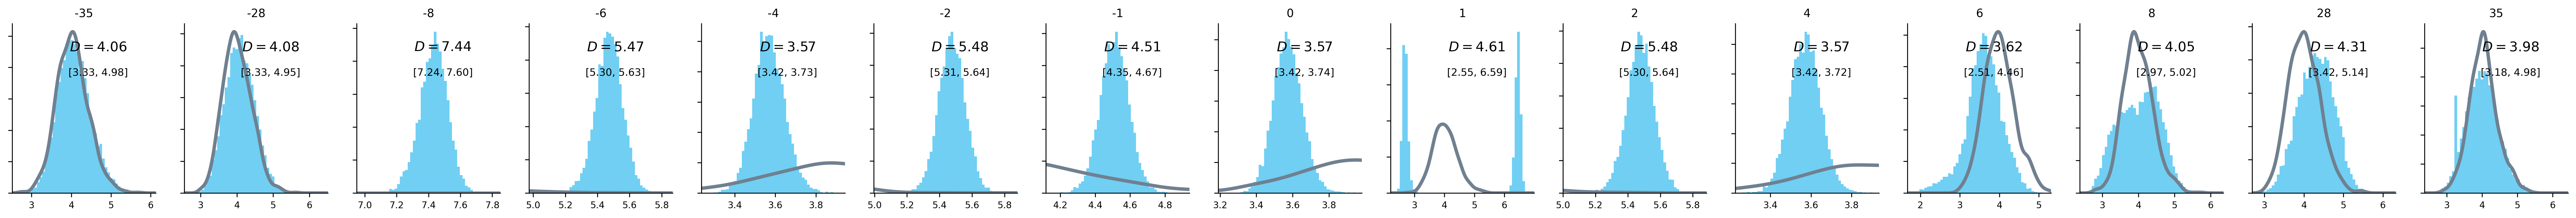

In [4]:
axes = plot_delays(traces,models)

for i,ax in enumerate(axes):
    ax.set_title(offsets[i])

plt.show()
plt.close(fig=axes[0].get_figure())

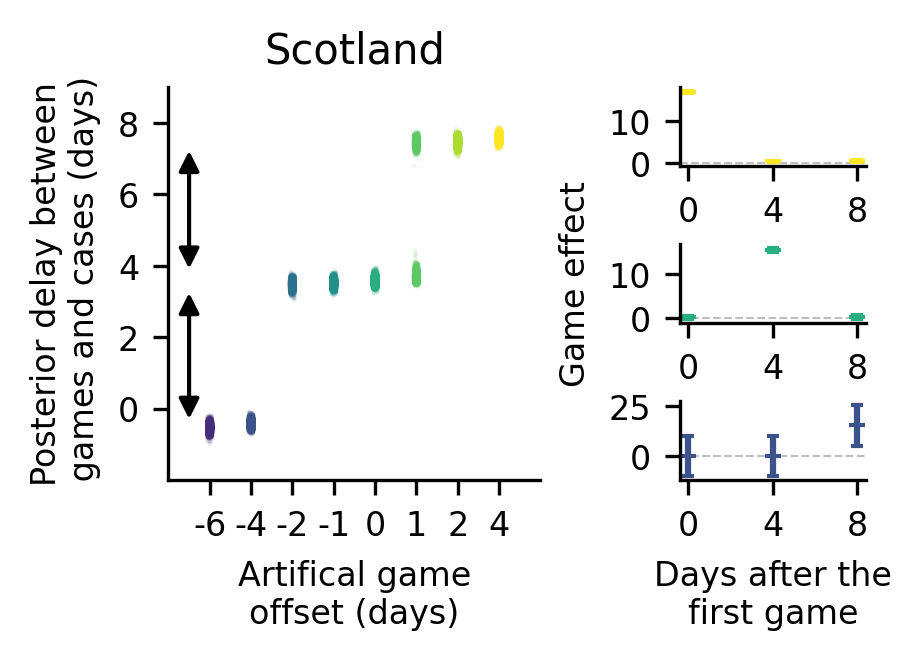

In [8]:
""" Prepare data for plotting
"""
x = []
df = []
ci = []
for i, trace in enumerate(traces):
    # Get data from trace
    delay = get_from_trace("delay",trace)
    
    # Handpick cluster if two delays are found
    if offsets[i] == 1:
        kmeans = KMeans(n_clusters=2)
        kmeans.fit_transform(delay)
        
        # Stack ci together
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 0,0], [50,2.5,97.5])])
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 1,0], [50,2.5,97.5])])
        #delay_ = np.stack((delay[kmeans.labels_ == 0,0],np.ones(len(delay[kmeans.labels_ == 0,0]))*offsets[i]),axis=1)
        
    else: # Default case
        ci.append([offsets[i],np.percentile(delay[:,0], [50,2.5,97.5])])
    delay_ = np.stack((delay[:,0],np.ones(len(delay))*offsets[i]),axis=1)   
    temp = pd.DataFrame(delay_,columns=["Delay","Offset"])   
    df.append(temp)

df = pd.concat(df)
df["Delay+Offset"] = df["Delay"]+df["Offset"]
df = df.sort_values("Offset")
df["Offset"] = df["Offset"].astype(int).astype(str)

""" Create plot
"""
fig = plt.figure(figsize=(3,1.7))

grid = fig.add_gridspec(3, 2, wspace=0.5, hspace=1, width_ratios=[1,0.5],height_ratios=[1,1,1])
selected_offsets = ["-6","-4","-2","-1","0","1","2","4"] #Scotland
cmap = sns.color_palette("viridis", as_cmap=True)
axes = []

""" Plot each delay posterior
"""
axes.append(fig.add_subplot(grid[:,0]))
violin=False
if not violin:
    sns.stripplot(
        x="Offset", y="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        alpha=.1,
        zorder=1,
        size=1.1,
        jitter=0.055, # half width of the normal
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))]
    )
else:
    sns.violinplot(
        x="Offset", y="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        zorder=1,
        size=1.1,
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
        inner=None, saturation=1,
        positions=[0,1,2]
    )
    # Set outline colors
    for i,col in enumerate(axes[0].collections):
        col.set_edgecolor(cmap((i+1)/len(selected_offsets))) 

    if False:
        sns.violinplot(
            x="Offset", y="Delay+Offset",
            data=extra,
            zorder=1,
            size=1.1,
            ax=axes[0],
            palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
            scale="count", inner=None,saturation=1, positions=6
        )        
        
lower=np.where(np.array(offsets) == -6)[0][0]
upper=np.where(np.array(offsets) == 4)[0][0]
axes[0].set_xlim(-1,len(selected_offsets))
axes[0].set_ylim(-2,9)
axes[0].set_yticks([0,2,4,6,8])


""" Plot three handpicked offsets (one from each group)
"""
for i,off in enumerate([4,0,-4]):
    axes.append(fig.add_subplot(grid[i,1]))
    covid19_soccer.plot.overview.plot_reproductionViolin(
        axes[i+1],
        traces[offsets.index(off)],
        models[offsets.index(off)],
        dls[offsets.index(off)],
        plot_dates=False,
        color=cmap((selected_offsets.index(str(off))+1)/len(selected_offsets))
    )
    
    # Markup
    axes[i+1].set_xticks([0,4,8])
    axes[i+1].set_ylabel("") # Remove label

        
""" Plot arrows between 
"""
axes[0].annotate("",
    xy=(-0.5, ci[offsets.index(-6)][1][0]-6, ), xycoords='data',
    xytext=(-0.5, ci[offsets.index(-2)][1][0]-2), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )

axes[0].annotate("",
    xy=(-0.5, ci[offsets.index(1)][1][0]+1), xycoords='data',
    xytext=(-0.5, ci[offsets.index(1)+1][1][0]+1), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )

# Remove all top and right frames
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
       
""" Set axis labels
"""
axes[3].set_xlabel("Days after the\nfirst game")
axes[0].set_xlabel("Artifical game\noffset (days)")
axes[0].set_ylabel("Posterior delay between\n games and cases (days)")
axes[0].set_title("Scotland")
axes[2].set_ylabel("Game effect")

""" Save plot
"""
fig_path = "./figures/validation"
country = "Scotland"
kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/delay_offset_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/delay_offset_{country}.png", **kwargs)
                
plt.show()
plt.close(fig=fig)

In [9]:
offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
models,traces,dls = load_models_traces_dataloader(
    "England",
    offsets
)

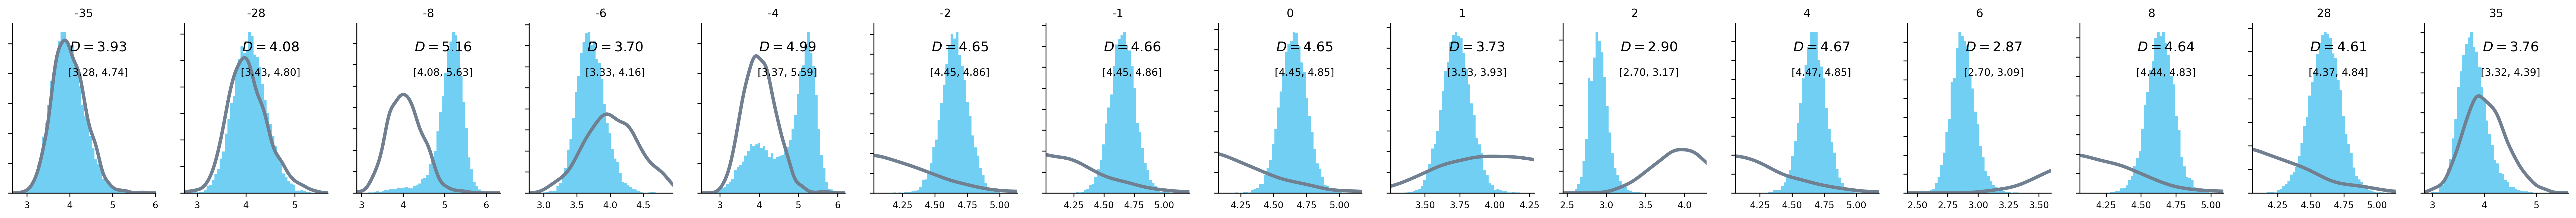

In [10]:
axes = plot_delays(traces,models)

for i,ax in enumerate(axes):
    ax.set_title(offsets[i])

plt.show()
plt.close(fig=axes[0].get_figure())

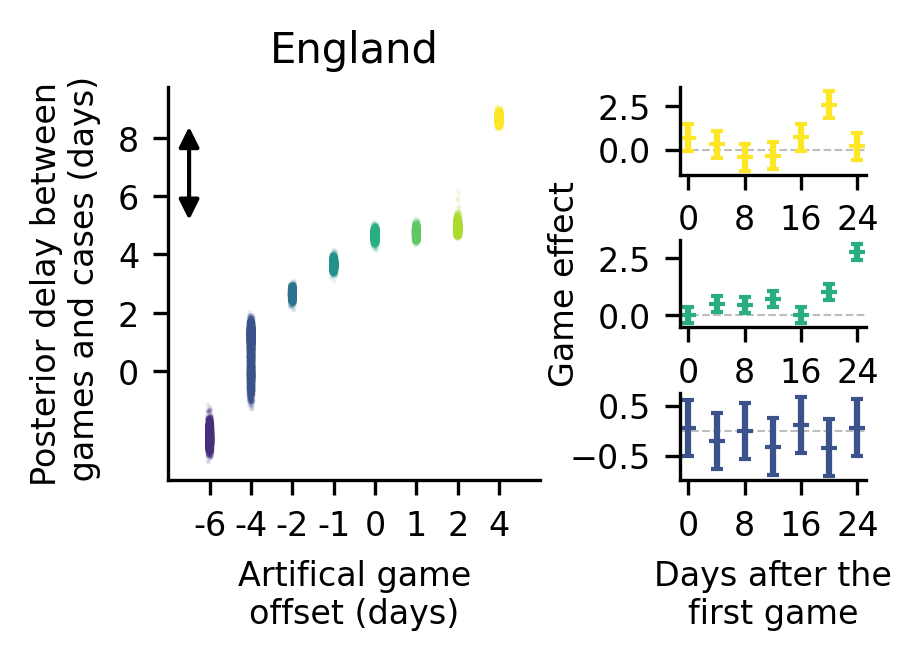

In [12]:
""" Prepare data for plotting
"""
x = []
df = []
ci = []
for i, trace in enumerate(traces):
    # Get data from trace
    delay = get_from_trace("delay",trace)
    
    # Handpick cluster if two delays are found
    if offsets[i] == 1:
        kmeans = KMeans(n_clusters=2)
        kmeans.fit_transform(delay)
        
        # Stack ci together
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 0,0], [50,2.5,97.5])])
        ci.append([offsets[i],np.percentile(delay[kmeans.labels_ == 1,0], [50,2.5,97.5])])
        #delay_ = np.stack((delay[kmeans.labels_ == 0,0],np.ones(len(delay[kmeans.labels_ == 0,0]))*offsets[i]),axis=1)
        
    else: # Default case
        ci.append([offsets[i],np.percentile(delay[:,0], [50,2.5,97.5])])
    delay_ = np.stack((delay[:,0],np.ones(len(delay))*offsets[i]),axis=1)   
    temp = pd.DataFrame(delay_,columns=["Delay","Offset"])   
    df.append(temp)

df = pd.concat(df)
df["Delay+Offset"] = df["Delay"]+df["Offset"]
df = df.sort_values("Offset")
df["Offset"] = df["Offset"].astype(int).astype(str)

""" Create plot
"""
fig = plt.figure(figsize=(3,1.7))

grid = fig.add_gridspec(3, 2, wspace=0.5, hspace=0.75, width_ratios=[1,0.5],height_ratios=[1,1,1])
selected_offsets = ["-6","-4","-2","-1","0","1","2","4"] #Scotland
cmap = sns.color_palette("viridis", as_cmap=True)
axes = []

""" Plot each delay posterior
"""
axes.append(fig.add_subplot(grid[:,0]))
violin=False
if not violin:
    sns.stripplot(
        x="Offset", y="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        alpha=.1,
        zorder=1,
        size=1.1,
        jitter=0.055, # half width of the normal
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))]
    )
else:
    sns.violinplot(
        x="Offset", y="Delay+Offset",
        data=df[df["Offset"].isin(selected_offsets)],
        zorder=1,
        size=1.1,
        ax=axes[0],
        palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
        inner=None,saturation=1,
        positions=[0,1,2]
    )
    # Set outline colors
    for i,col in enumerate(axes[0].collections):
        col.set_edgecolor(cmap((i+1)/len(selected_offsets))) 

    if False:
        sns.violinplot(
            x="Offset", y="Delay+Offset",
            data=extra,
            zorder=1,
            size=1.1,
            ax=axes[0],
            palette=[cmap((i+1)/len(selected_offsets)) for i in range((len(selected_offsets)))],
            scale="count", inner=None,saturation=1, positions=6
        )        
        
lower=np.where(np.array(offsets) == -6)[0][0]
upper=np.where(np.array(offsets) == 4)[0][0]
axes[0].set_xlim(-1,len(selected_offsets))
axes[0].set_yticks([0,2,4,6,8])


""" Plot three handpicked offsets (one from each group)
"""
for i,off in enumerate([4,0,-4]):
    axes.append(fig.add_subplot(grid[i,1]))
    covid19_soccer.plot.overview.plot_reproductionViolin(
        axes[i+1],
        traces[offsets.index(off)],
        models[offsets.index(off)],
        dls[offsets.index(off)],
        plot_dates=False,
        color=cmap((selected_offsets.index(str(off))+1)/len(selected_offsets))
    )
    
    # Markup
    axes[i+1].set_xticks([0,8,16,24])
    axes[i+1].set_ylabel("") # Remove label

        
""" Plot arrows between 
"""
axes[0].annotate("",
    xy=(-0.5,ci[offsets.index(2)+1][1][0]+2), xycoords='data',
    xytext=(-0.5,ci[offsets.index(4)+1][1][0]+4), textcoords='data',
    arrowprops=dict(arrowstyle="<|-|>",
                    connectionstyle="arc3",
                    color="black",
                   ),
    )



# Remove all top and right frames
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
       
""" Set axis labels
"""
axes[3].set_xlabel("Days after the\nfirst game")
axes[0].set_xlabel("Artifical game\noffset (days)")
axes[0].set_ylabel("Posterior delay between\n games and cases (days)")
axes[0].set_title("England")
axes[2].set_ylabel("Game effect")
axes[3].set_yticks([-0.5,0.5])
""" Save plot
"""
fig_path = "./figures/validation"
country = "England"
kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/delay_offset_{country}.pdf", **kwargs)
fig.savefig(f"{fig_path}/delay_offset_{country}.png", **kwargs)
                
plt.show()
plt.close(fig=fig)

## Longer timespan plots

In [11]:
models,traces,dls = load_models_traces_dataloader(
    "France",
    [0],
)
model = models[0]
trace = traces[0]
dl = dls[0]

In [35]:
tune=1000
draws=1500
max_treedepth=12
country = "France"
fstr=(f"/data.nst/jdehning/covid_uefa_traces/UEFA"+
    f"-beta={True}"+
    f"-country={country}"+
    f"-offset_games={0}"+
    f"-draw_delay={True}"+
    f"-weighted_alpha_prior=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    #f"-median_width_delay={1.5}"+
    f"-tune={tune}"+
    f"-draws={draws}"+
    f"-max_treedepth={max_treedepth}.pickled")   
model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=0)

/tmp/ipykernel_942634/1809383793.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([0], [0], color=colors["fraction"],lw=2.5,),


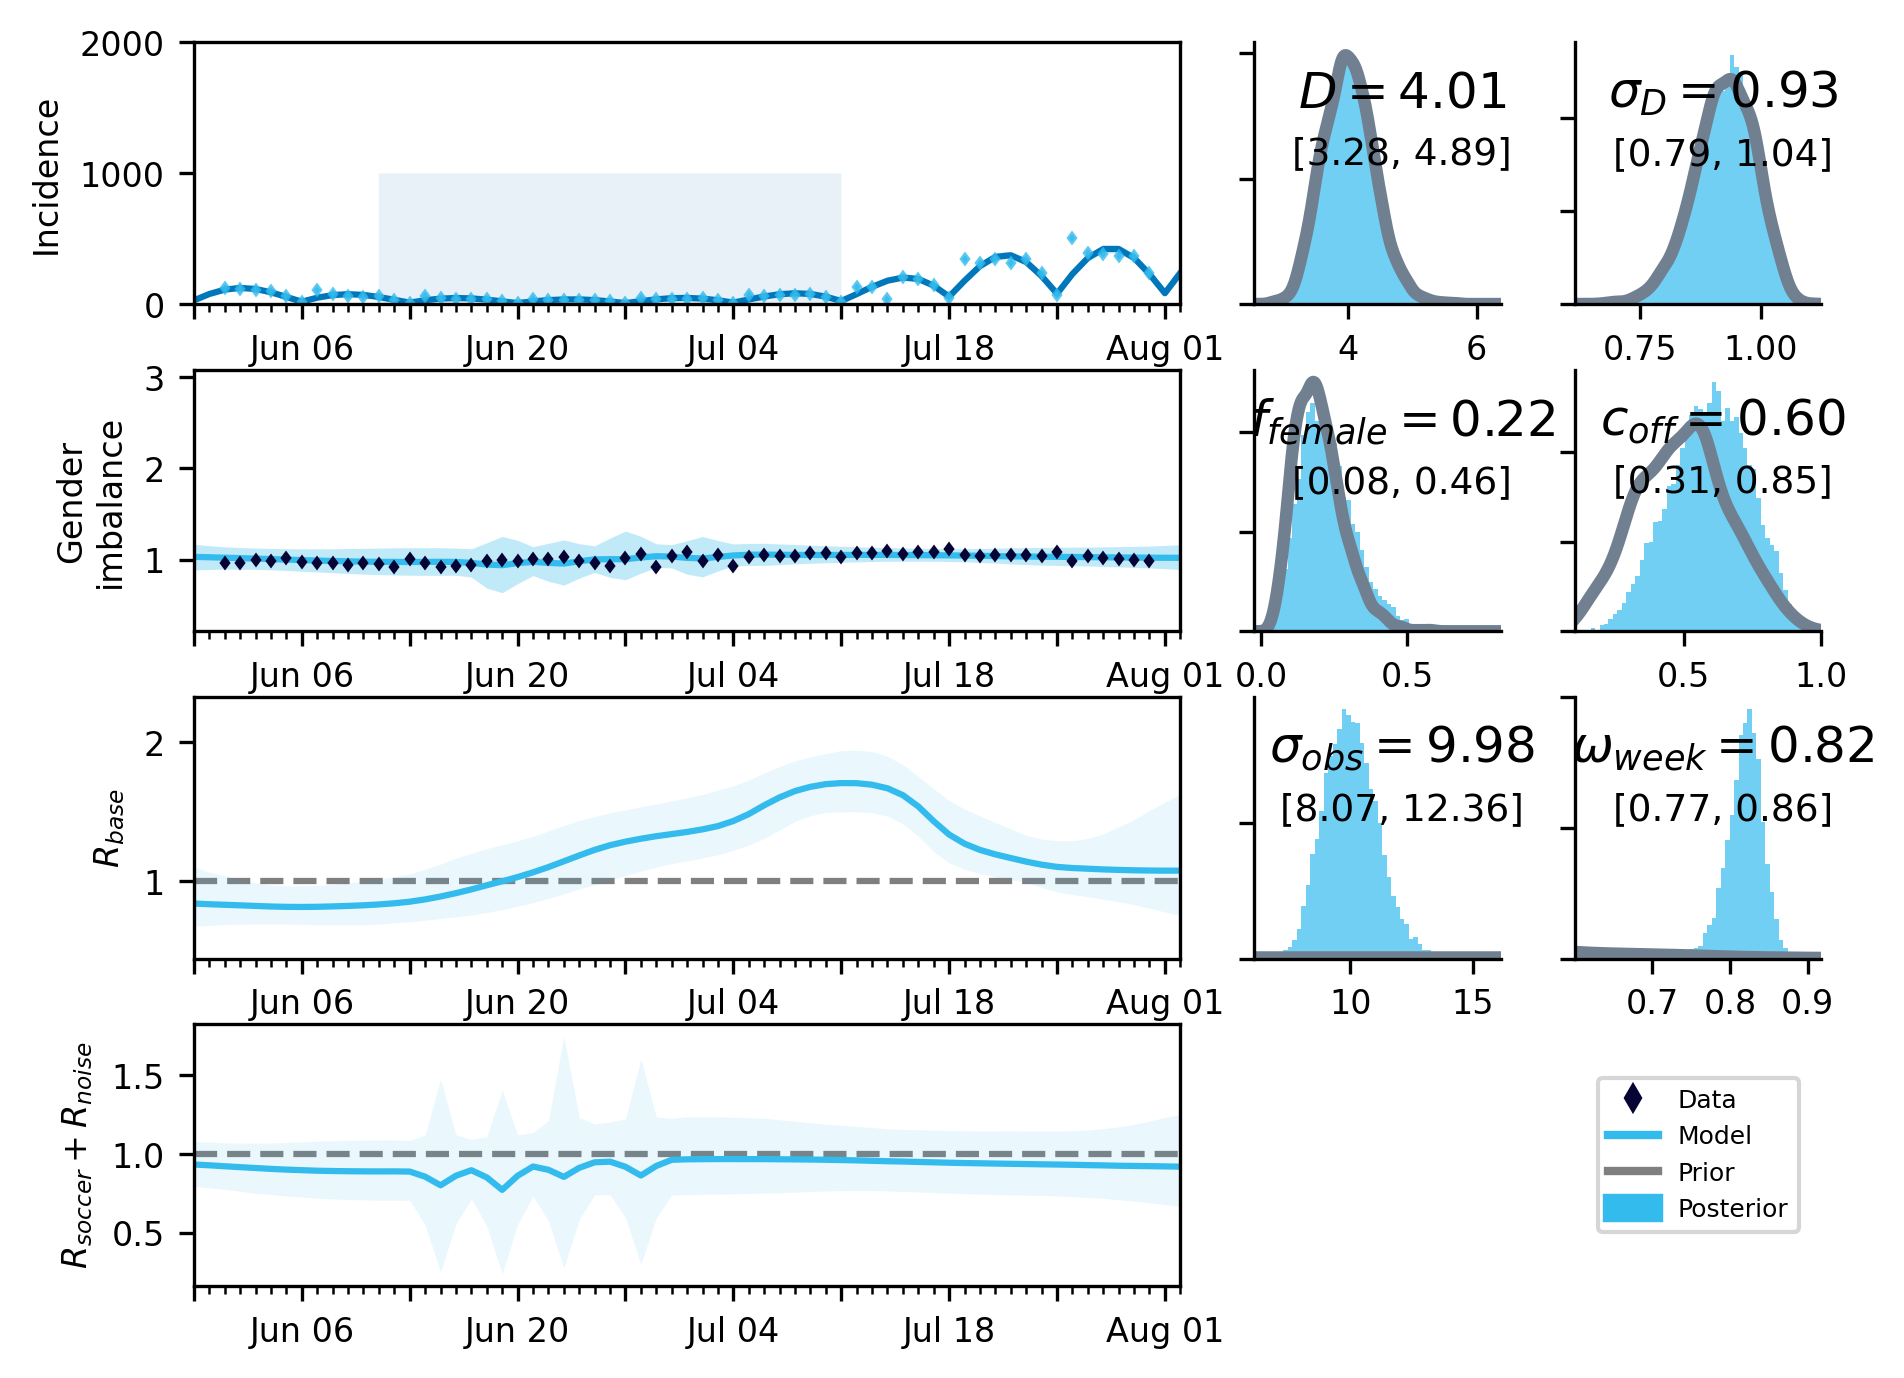

In [44]:
from covid19_soccer.plot.rcParams import colors
# R_base
# R_soccer
# imbalance
# cases

fig = plt.figure(figsize=(7,1.7*4))
grid = fig.add_gridspec(5, 3, wspace=0.15, hspace=0.25,width_ratios=[1,0.25,0.25])
dates = pd.date_range(model.sim_begin,model.sim_end)
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,8,2)] # Plotting range
axes_ts = []

""" Cases
"""
ax = fig.add_subplot(grid[0,0])
covid19_soccer.plot.overview.plot_cases(
    ax=ax,
    trace=trace,
    model=model,
    dl=dl,
    color=colors["fraction"]
)
axes_ts.append(ax)
#Diry hack: Disable every second ticklabel
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_ylim(0,2000)

""" Gender imbalance
"""
ax = fig.add_subplot(grid[1,0])
covid19_soccer.plot.overview.plot_fraction(
    ax=ax,
    trace=trace,
    model=model,
    dl=dl,
    
)
axes_ts.append(ax)

"""R_base
"""
R_base = get_from_trace("R_t_base", trace)

ax = fig.add_subplot(grid[2,0])
cov19.plot._timeseries(
    x=dates,
    y=R_base,
    ax=ax,
    what="model",
    color=colors["fraction"]
)
ax.axhline(1,ls="--",color="tab:gray",zorder=-100)
ax.set_ylabel("$R_{base}$")
#ax.set_ylim(0.5,1.5)
#Diry hack: Disable every second ticklabel
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
axes_ts.append(ax)

""" R soccer
"""
R_soccer = get_from_trace("R_t_soccer", trace)
R_noise = get_from_trace("R_t_add_noise_fact", trace)[:,:,0]

ax = fig.add_subplot(grid[3,0])
cov19.plot._timeseries(
    x=dates,
    y=R_soccer+R_noise,
    ax=ax,
    what="model",
    color=colors["fraction"]
)
ax.axhline(1,ls="--",color="tab:gray",zorder=-100)
ax.set_ylabel("$R_{soccer}+R_{noise}$")

#ax.set_ylim(-0.5,2)
#Diry hack: Disable every second ticklabel
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
axes_ts.append(ax)   


""" Distributions
"""
ax = fig.add_subplot(grid[0,1])
covid19_soccer.plot.distribution(
    model,
    trace,
    "delay",
    nSamples_prior=5000,
    title="",
    dist_math="D",
    ax=ax,
)

ax = fig.add_subplot(grid[0,2])
covid19_soccer.plot.distribution(
    model,
    trace,
    "delay-width",
    nSamples_prior=5000,
    title="",
    dist_math="\sigma_{D}", #What was
    ax = ax
)

ax = fig.add_subplot(grid[1,1])
covid19_soccer.plot.distribution(
    model,
    trace,
    "factor_female",
    nSamples_prior=5000,
    title="",
    dist_math="f_{female}", #What was
    ax = ax
)
ax = fig.add_subplot(grid[1,2])
covid19_soccer.plot.distribution(
    model,
    trace,
    "c_off",
    nSamples_prior=1000,
    title="",
    dist_math="c_{off}",
    ax=ax,
)

ax = fig.add_subplot(grid[2,1])
covid19_soccer.plot.distribution(
    model,
    trace,
    "sigma_obs",
    nSamples_prior=1000,
    title="",
    dist_math="\sigma_{obs}",
    ax=ax,
)

# I_begin
ax = fig.add_subplot(grid[2,2])
covid19_soccer.plot.distribution(
    model,
    trace,
    "weekend_factor",
    nSamples_prior=1000,
    title="",
    dist_math="\omega_{week}", #What was
    ax=ax,
)

""" Legend
"""
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [
    Line2D([0], [0], marker='d', color=colors["data"], label='Scatter', markersize=4,lw=0),
    Line2D([0], [0], color=colors["fraction"], lw=2),
    Line2D([0], [0], color="tab:gray", lw=2),
    Patch([0], [0], color=colors["fraction"],lw=2.5,),
               
               ]
ax = fig.add_subplot(grid[3,2])
ax.legend(custom_lines, ['Data','Model','Prior','Posterior',],loc="center")
ax.axis('off')


for ax in axes_ts:
    ax.set_xlim(xlim_ts)
plt.show()
plt.close(fig=fig)